# Multi-class Image Classification with transfer learning, data augmentation and model fine-tuning

- Objective: Multiclass image classification
- Dataset: CIFAR100
- Deep learning techniques used:
  - Transfer learning (MobileNetV2 architecture pre-trained with ImageNet dataset)
  - Data augmentation
  - Model fine-tuning

In [35]:
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

## Data preparation

In [92]:
cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()

In [93]:
print("Tensor shapes:")
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)

Tensor shapes:
x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


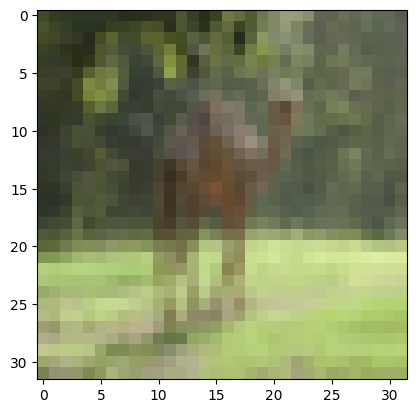

In [94]:
random_example_index = random.randint(0,x_train.shape[0]+1)

example_image = x_train[random_example_index]
plt.imshow(example_image)

## Model definition

### Architecture

In [124]:
def model (input_shape:tuple[int,int,int], num_classes:int) -> tf.keras.Model:

  # Base model is MobileNetV2 architecture with ImageNet dataset weights
  base_model = tf.keras.applications.MobileNetV2(
      input_shape=input_shape,
      include_top=False,
      weights='imagenet'
      )

  # Freeze the base model by making it non trainable
  base_model.trainable = False

  # Create input layer
  inputs = tf.keras.Input(shape=input_shape)

  # Apply data augmentation to inputs (only works during training)
  data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
  ])
  x = data_augmentation(inputs)

  # Preprocess data using the same weights the model was trained on
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

  # Set training to False to avoid keeping track of statistics in the batch norm layer
  x = base_model(x, training=False)

  # Final layers

  # GlobalAveragePooling2D to summarize the info in each channel
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # Dropout to avoid overfitting
  x = tf.keras.layers.Dropout(rate=0.2)(x)

  # Output prediction layer for multi-class classification
  outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model


# Create model instance with defined input shape and number of classes
model = model(
    input_shape=tuple(x_train.shape[1:]),
    num_classes=len(set(y_train.flatten().tolist()))
)

### Optimization settings

In [125]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

# Compile the model with the defined settings
model.compile(optimizer=optimizer,loss=loss_function,metrics=metrics)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_30 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 32, 32, 3)        0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 32, 32, 3)        0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                          

## Initial training

In [126]:
initial_epochs = 5

history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,   # Fraction of the data to use as validation
    shuffle=True,           # Shuffles data before each epoch
    epochs=initial_epochs,
    batch_size=256
)

Epoch 1/5
157/157 [==============================] - 31s 181ms/step - loss: 4.5475 - accuracy: 0.0275 - val_loss: 4.4941 - val_accuracy: 0.0415
Epoch 2/5
157/157 [==============================] - 24s 151ms/step - loss: 4.4471 - accuracy: 0.0535 - val_loss: 4.4223 - val_accuracy: 0.0556
Epoch 3/5
157/157 [==============================] - 24s 156ms/step - loss: 4.3795 - accuracy: 0.0641 - val_loss: 4.3715 - val_accuracy: 0.0669
Epoch 4/5
157/157 [==============================] - 24s 156ms/step - loss: 4.3353 - accuracy: 0.0704 - val_loss: 4.3330 - val_accuracy: 0.0734
Epoch 5/5
157/157 [==============================] - 24s 151ms/step - loss: 4.2990 - accuracy: 0.0743 - val_loss: 4.3032 - val_accuracy: 0.0788


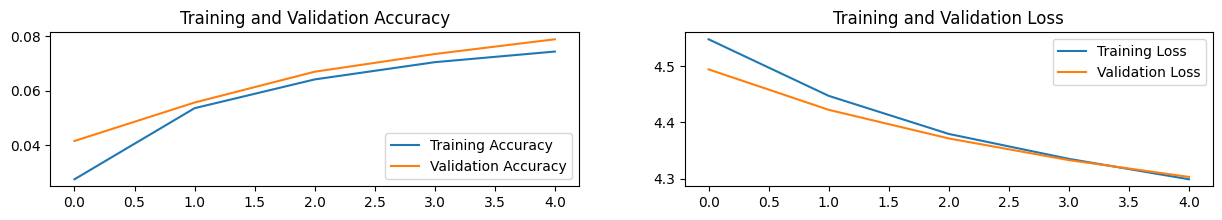

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

initial_epochs_range = range(initial_epochs)

plt.figure(figsize=(15, 2))
plt.subplot(1, 2, 1)
plt.plot(initial_epochs_range, acc, label='Training Accuracy')
plt.plot(initial_epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(initial_epochs_range, loss, label='Training Loss')
plt.plot(initial_epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine-tuning

In [128]:
# Enable training for the last 20% of layers of the base model
base_model = model.layers[4]

for layer in base_model.layers[int(0.8*len(base_model.layers)):]:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizer,loss=loss_function,metrics=metrics)

# Fine tune for more epochs
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,   # Fraction of the data to use as validation
    shuffle=True,           # Shuffles data before each epoch
    epochs=fine_tune_epochs,
    batch_size=256
)

Epoch 1/5
157/157 [==============================] - 29s 165ms/step - loss: 4.2701 - accuracy: 0.0764 - val_loss: 4.2788 - val_accuracy: 0.0807
Epoch 2/5
157/157 [==============================] - 24s 155ms/step - loss: 4.2437 - accuracy: 0.0781 - val_loss: 4.2587 - val_accuracy: 0.0815
Epoch 3/5
157/157 [==============================] - 23s 149ms/step - loss: 4.2275 - accuracy: 0.0786 - val_loss: 4.2422 - val_accuracy: 0.0825
Epoch 4/5
157/157 [==============================] - 24s 150ms/step - loss: 4.2134 - accuracy: 0.0775 - val_loss: 4.2287 - val_accuracy: 0.0839
Epoch 5/5
157/157 [==============================] - 23s 149ms/step - loss: 4.2002 - accuracy: 0.0821 - val_loss: 4.2168 - val_accuracy: 0.0866


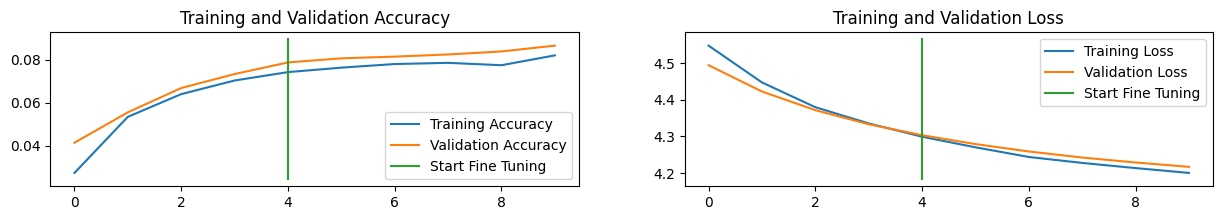

In [129]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

total_epochs_range = range(total_epochs)

plt.figure(figsize=(15, 2))
plt.subplot(1, 2, 1)
plt.plot(total_epochs_range, acc, label='Training Accuracy')
plt.plot(total_epochs_range, val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(total_epochs_range, loss, label='Training Loss')
plt.plot(total_epochs_range, val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Next steps

After initial training and fine-tuning, the model accuracy is still quite low. Some next steps to explore could be:

- Continue training for an extended number of epochs
- Improve the input dataset (e.g., more and/or better images)
- Experiment with different architectures and hyperparameters:
  - Base architecture (currently: MobileNetV2)
  - Transfer learning (currently: parameters taken from MobileNetV2 trained on ImageNet dataset)
  - Output layers (currently: GlobalAveragePooling2D -> Dropout -> Dense with softmax activation)
  - Hyperparameters such as learning rate, validation split, batch size, etc.